In [1]:
'''
!pip install -U --pre tensorflow=="2.*"
!pip install tf_slim
'''

'\n!pip install -U --pre tensorflow=="2.*"\n!pip install tf_slim\n'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip /content/drive/MyDrive/CN/cw_dataset.zip -d /content/drive/MyDrive/CN/unzip

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/CN/unzip/imageset/train/n01440764/n01440764_6497.JPEG  
  inflating: /content/drive/MyDrive/CN/unzip/imageset/train/n01440764/n01440764_14435.JPEG  
  inflating: /content/drive/MyDrive/CN/unzip/imageset/train/n01440764/n01440764_10026.JPEG  
  inflating: /content/drive/MyDrive/CN/unzip/imageset/train/n01440764/n01440764_6643.JPEG  
  inflating: /content/drive/MyDrive/CN/unzip/imageset/train/n01440764/n01440764_925.JPEG  
  inflating: /content/drive/MyDrive/CN/unzip/imageset/train/n01440764/n01440764_6706.JPEG  
  inflating: /content/drive/MyDrive/CN/unzip/imageset/train/n01440764/n01440764_26006.JPEG  
  inflating: /content/drive/MyDrive/CN/unzip/imageset/train/n01440764/n01440764_5203.JPEG  
  inflating: /content/drive/MyDrive/CN/unzip/imageset/train/n01440764/n01440764_2196.JPEG  
  inflating: /content/drive/MyDrive/CN/unzip/imageset/train/n01440764/n01440764_4804.JPEG  
  inflating: /content/drive

Found 9469 files belonging to 10 classes.
Found 3925 files belonging to 10 classes.


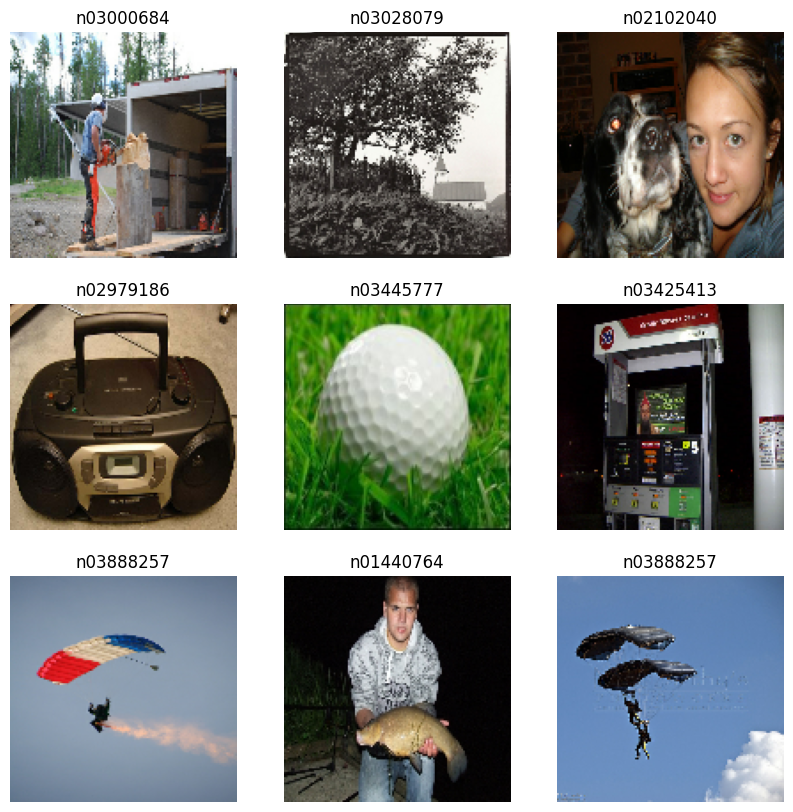

In [18]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.utils import image_dataset_from_directory
import pandas as pd

BATCH_SIZE = 32
IMG_SIZE = (128, 128)
train_dir = '/content/drive/MyDrive/CN/unzip/imageset/train'
test_dir = '/content/drive/MyDrive/CN/unzip/imageset/val'

def normalize_img(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_dataset = image_dataset_from_directory(train_dir,shuffle=True,batch_size=BATCH_SIZE,image_size=IMG_SIZE)
test_dataset = image_dataset_from_directory(test_dir,shuffle=False,batch_size=BATCH_SIZE,image_size=IMG_SIZE)

class_names = train_dataset.class_names

train_dataset = train_dataset.map(normalize_img)
test_dataset = test_dataset.map(normalize_img)

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(class_names[int(labels[i].numpy())])
        plt.axis("off")
plt.show()

In [5]:
# Step 1: Shallow CNN Model

class MyModel(models.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = Conv2D(32, 3, activation='relu', padding='same')
        self.pool1 = MaxPool2D(pool_size=2)
        self.flatten = Flatten()
        self.d1 = Dense(128, activation='relu')
        self.d2 = Dense(10)

    def call(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.flatten(x)
        x = self.d1(x)
        return self.d2(x)

In [6]:
model = MyModel()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [7]:
def train_step(images, labels):
  with tf.GradientTape() as tape:
    predictions = model(images, training=True)
    loss = loss_object(labels, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_loss(loss)
    train_accuracy(labels, predictions)

def test_step(images, labels):
    predictions = model(images, training=False)
    t_loss = loss_object(labels, predictions)
    test_loss(t_loss)
    test_accuracy(labels, predictions)

Epoch 1, Loss: 2.2591795921325684, Accuracy: 38.51515352725983, Test Loss: 1.5752094984054565, Test Accuracy: 47.92356789112091
Epoch 2, Loss: 1.077683925628662, Accuracy: 65.73027968406677, Test Loss: 1.41916024684906, Test Accuracy: 55.18471598625183
Epoch 3, Loss: 0.6187489032745361, Accuracy: 81.8777084350586, Test Loss: 1.4690704345703125, Test Accuracy: 55.79617619514465
Epoch 4, Loss: 0.2997916340827942, Accuracy: 92.25894808769226, Test Loss: 1.5774085521697998, Test Accuracy: 57.044583559036255
Epoch 5, Loss: 0.1384141445159912, Accuracy: 97.13802933692932, Test Loss: 1.756838083267212, Test Accuracy: 56.5605103969574
Epoch 6, Loss: 0.05703766271471977, Accuracy: 98.99672865867615, Test Loss: 2.0247251987457275, Test Accuracy: 55.61783313751221
Epoch 7, Loss: 0.029123777523636818, Accuracy: 99.57756996154785, Test Loss: 2.099196434020996, Test Accuracy: 56.89172148704529
Epoch 8, Loss: 0.03484542667865753, Accuracy: 99.37691688537598, Test Loss: 2.833906888961792, Test Accurac

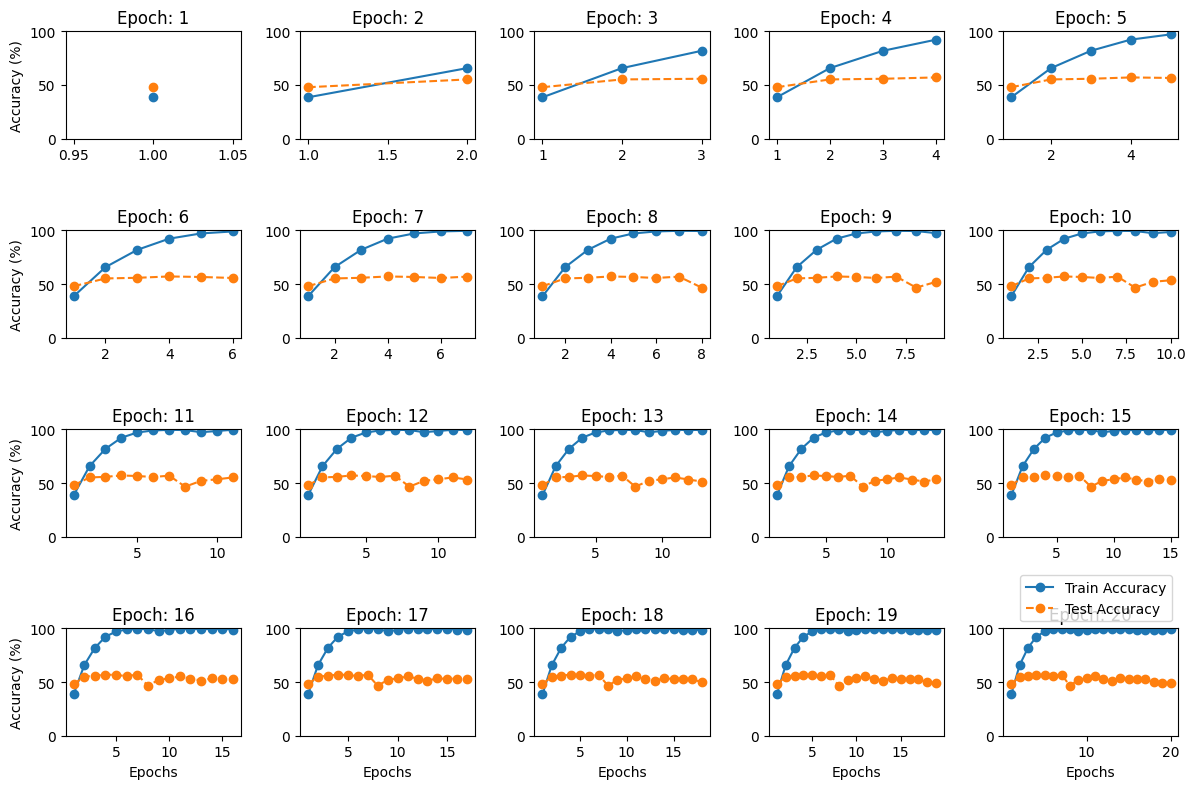

In [8]:
# Code adapted from:[https://huangdi.tistory.com/9]

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

EPOCHS = 20
epochs_range = np.arange(1, EPOCHS + 1)

for epoch in range(EPOCHS):
    train_loss.reset_state()
    train_accuracy.reset_state()
    test_loss.reset_state()
    test_accuracy.reset_state()

    for images, labels in train_dataset:
        train_step(images, labels)

    for images, labels in test_dataset:
        test_step(images, labels)

    train_losses.append(train_loss.result().numpy())
    train_accuracies.append(train_accuracy.result().numpy() * 100)
    test_losses.append(test_loss.result().numpy())
    test_accuracies.append(test_accuracy.result().numpy() * 100)

    print(f'Epoch {epoch + 1}, '
          f'Loss: {train_losses[-1]}, '
          f'Accuracy: {train_accuracies[-1]}, '
          f'Test Loss: {test_losses[-1]}, '
          f'Test Accuracy: {test_accuracies[-1]}')

#Visualization
plt.figure(figsize=(12, 8))

for i, epoch in enumerate(epochs_range):
    plt.subplot(4, 5, i+1)
    plt.title(f"Epoch: {epoch}")

    if i == len(epochs_range) - 1:
        plt.plot(epochs_range[:i+1], train_accuracies[:i+1], label="Train Accuracy", marker='o')
        plt.plot(epochs_range[:i+1], test_accuracies[:i+1], linestyle="--", label="Test Accuracy", marker='o')
    else:
        plt.plot(epochs_range[:i+1], train_accuracies[:i+1], marker='o')
        plt.plot(epochs_range[:i+1], test_accuracies[:i+1], linestyle="--", marker='o')

    plt.ylim(0, 100)

    if i % 5 == 0:
        plt.ylabel("Accuracy (%)")
    if i >= len(epochs_range) - 5:
        plt.xlabel("Epochs")

plt.legend(loc="lower right", bbox_to_anchor=(1.0,1.0))
plt.tight_layout()
plt.show()

In [10]:
# Data Augmentation, Batch Normalization and hyperparameter modify applied CNN
# Code adapted from:[https://www.kaggle.com/code/eugeniyosetrov/using-data-augmentation-for-cnn]

ds_train = image_dataset_from_directory(
    directory='/content/drive/MyDrive/CN/unzip/imageset/train',
    label_mode='int',
    labels='inferred',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True)

ds_valid = image_dataset_from_directory(
    directory='/content/drive/MyDrive/CN/unzip/imageset/val',
    label_mode='int',
    labels='inferred',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False)

Found 9469 files belonging to 10 classes.
Found 3925 files belonging to 10 classes.


In [11]:
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE

ds_train = (
    ds_train
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

ds_valid = (
    ds_valid
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

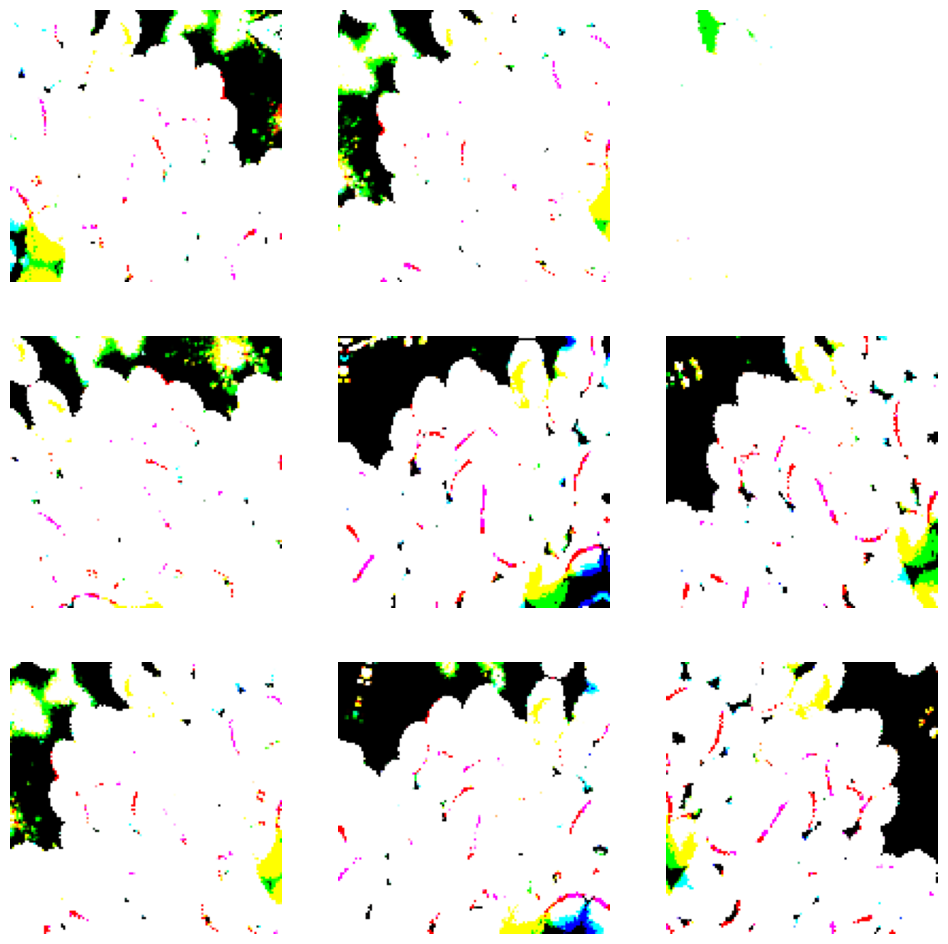

In [12]:
augmentation = keras.Sequential([

tf.keras.layers.RandomContrast(factor=0.9),
tf.keras.layers.RandomFlip(mode='horizontal'),
tf.keras.layers.RandomRotation(factor=0.10),
])

next_one = next(iter(ds_train.unbatch().map(lambda x, y: x).batch(1)))

plt.figure(figsize=(12,12))
for i in range(9):
    image = augmentation(next_one, training=True)
    plt.subplot(3, 3, i+1)
    plt.imshow(tf.squeeze(image))
    plt.axis('off')
plt.show()

In [13]:
#relu

num_classes = 10

model1 = keras.Sequential([
    layers.InputLayer(shape=[128, 128, 3]),

    tf.keras.layers.RandomContrast(factor=0.10),
    tf.keras.layers.RandomFlip(mode='horizontal'),
    tf.keras.layers.RandomRotation(factor=0.10),

    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(),

    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(),

    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(),

    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax'),
])

In [25]:
#selu

num_classes = 10

model2 = keras.Sequential([
    layers.InputLayer(shape=[128, 128, 3]),

    tf.keras.layers.RandomContrast(factor=0.10),
    tf.keras.layers.RandomFlip(mode='horizontal'),
    tf.keras.layers.RandomRotation(factor=0.10),

    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='selu', padding='same'),
    tf.keras.layers.MaxPool2D(),

    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation='selu', padding='same'),
    tf.keras.layers.MaxPool2D(),

    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation='selu', padding='same'),
    tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation='selu', padding='same'),
    tf.keras.layers.MaxPool2D(),

    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='selu'),
    tf.keras.layers.Dense(num_classes, activation='softmax'),
])

In [15]:
optimizer = tf.keras.optimizers.Adam(epsilon=0.01)

model1.compile(
    optimizer = optimizer,
    loss = 'sparse_categorical_crossentropy',
    metrics =  ['accuracy'])

history_01 = model1.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=20,
    verbose=True
)

Epoch 1/20
296/296 ━━━━━━━━━━━━━━━━━━━━ 37s 106ms/step - accuracy: 0.3828 - loss: 2.0256 - val_accuracy: 0.3152 - val_loss: 2.5823
Epoch 2/20
296/296 ━━━━━━━━━━━━━━━━━━━━ 20s 67ms/step - accuracy: 0.5581 - loss: 1.3603 - val_accuracy: 0.5648 - val_loss: 1.3623
Epoch 3/20
296/296 ━━━━━━━━━━━━━━━━━━━━ 20s 67ms/step - accuracy: 0.6368 - loss: 1.1237 - val_accuracy: 0.6367 - val_loss: 1.1790
Epoch 4/20
296/296 ━━━━━━━━━━━━━━━━━━━━ 20s 67ms/step - accuracy: 0.6844 - loss: 0.9836 - val_accuracy: 0.5992 - val_loss: 1.3276
Epoch 5/20
296/296 ━━━━━━━━━━━━━━━━━━━━ 20s 67ms/step - accuracy: 0.7171 - loss: 0.8647 - val_accuracy: 0.6392 - val_loss: 1.2301
Epoch 6/20
296/296 ━━━━━━━━━━━━━━━━━━━━ 20s 67ms/step - accuracy: 0.7565 - loss: 0.7512 - val_accuracy: 0.6357 - val_loss: 1.2973
Epoch 7/20
296/296 ━━━━━━━━━━━━━━━━━━━━ 20s 67ms/step - accuracy: 0.7754 - loss: 0.6742 - val_accuracy: 0.6525 - val_loss: 1.2221
Epoch 8/20
296/296 ━━━━━━━━━━━━━━━━━━━━ 20s 67ms/step - accuracy: 0.8054 - loss: 0.6042 -

In [26]:
optimizer_2 = tf.keras.optimizers.Adam(epsilon=0.01)

model2.compile(
    optimizer = optimizer_2,
    loss = 'sparse_categorical_crossentropy',
    metrics =  ['accuracy'])

history_02 = model2.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=20,
    verbose=True
)

Epoch 1/20
296/296 ━━━━━━━━━━━━━━━━━━━━ 28s 81ms/step - accuracy: 0.3017 - loss: 4.5852 - val_accuracy: 0.4525 - val_loss: 1.7866
Epoch 2/20
296/296 ━━━━━━━━━━━━━━━━━━━━ 22s 75ms/step - accuracy: 0.4817 - loss: 1.6092 - val_accuracy: 0.5241 - val_loss: 1.5002
Epoch 3/20
296/296 ━━━━━━━━━━━━━━━━━━━━ 22s 74ms/step - accuracy: 0.5582 - loss: 1.3517 - val_accuracy: 0.5656 - val_loss: 1.4825
Epoch 4/20
296/296 ━━━━━━━━━━━━━━━━━━━━ 22s 74ms/step - accuracy: 0.6009 - loss: 1.2211 - val_accuracy: 0.5845 - val_loss: 1.3582
Epoch 5/20
296/296 ━━━━━━━━━━━━━━━━━━━━ 22s 75ms/step - accuracy: 0.6323 - loss: 1.1143 - val_accuracy: 0.6127 - val_loss: 1.3223
Epoch 6/20
296/296 ━━━━━━━━━━━━━━━━━━━━ 22s 75ms/step - accuracy: 0.6673 - loss: 1.0175 - val_accuracy: 0.6344 - val_loss: 1.2059
Epoch 7/20
296/296 ━━━━━━━━━━━━━━━━━━━━ 22s 75ms/step - accuracy: 0.6898 - loss: 0.9339 - val_accuracy: 0.6334 - val_loss: 1.2258
Epoch 8/20
296/296 ━━━━━━━━━━━━━━━━━━━━ 22s 75ms/step - accuracy: 0.7098 - loss: 0.8938 - 

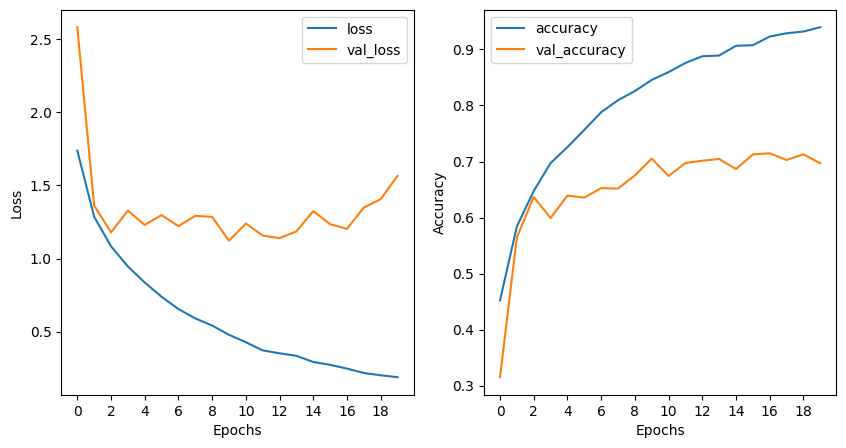

Best Validation Loss for Model 1: 1.1222
Best Validation Accuracy for Model 1: 0.7146


In [24]:
history_frame_01 = pd.DataFrame(history_01.history)

#Loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history_frame_01.index, history_frame_01['loss'], label='loss')
plt.plot(history_frame_01.index, history_frame_01['val_loss'], label='val_loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.xticks(np.arange(0, len(history_frame_01.index), step=2))

#Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_frame_01.index, history_frame_01['accuracy'], label='accuracy')
plt.plot(history_frame_01.index, history_frame_01['val_accuracy'], label='val_accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.xticks(np.arange(0, len(history_frame_01.index), step=2))

plt.show()

print(("Best Validation Loss for Model 1: {:0.4f}" +
       "\nBest Validation Accuracy for Model 1: {:0.4f}")
       .format(history_frame_01['val_loss'].min(),
               history_frame_01['val_accuracy'].max()))

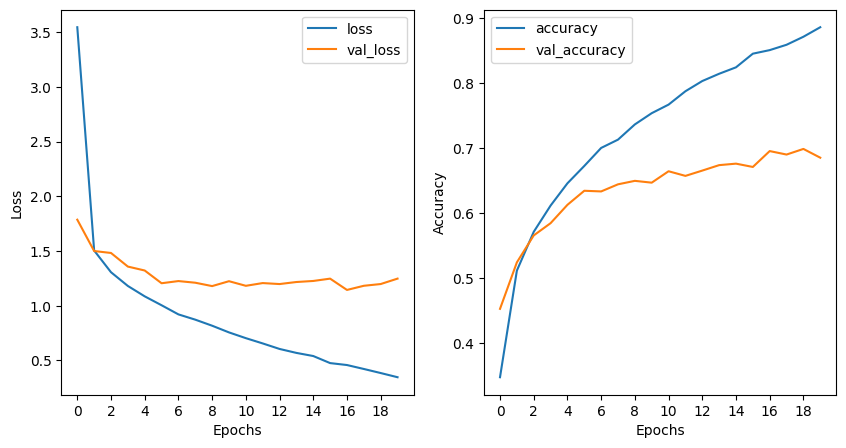

Best Validation Loss for Model 2: 1.1447
Best Validation Accuracy for Model 2: 0.6989


In [27]:
history_frame_02 = pd.DataFrame(history_02.history)

#Loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history_frame_02.index, history_frame_02['loss'], label='loss')
plt.plot(history_frame_02.index, history_frame_02['val_loss'], label='val_loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.xticks(np.arange(0, len(history_frame_02.index), step=2))

#Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_frame_02.index, history_frame_02['accuracy'], label='accuracy')
plt.plot(history_frame_02.index, history_frame_02['val_accuracy'], label='val_accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.xticks(np.arange(0, len(history_frame_02.index), step=2))

plt.show()

print(("Best Validation Loss for Model 2: {:0.4f}" +
       "\nBest Validation Accuracy for Model 2: {:0.4f}")
       .format(history_frame_02['val_loss'].min(),
               history_frame_02['val_accuracy'].max()))

In [21]:
#VGG-19 Model
#Code adapted from:[https://www.kaggle.com/code/sumedhbhamre/vgg19]

from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization

base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

x = Flatten()(base_model.output)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(10, activation='softmax')(x)


model = Model(inputs=base_model.input, outputs=x)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 26,550,090 (101.28 MB)

 Trainable params: 6,475,530 (24.70 MB)

 Non-trainable params: 20,074,560 (76.58 MB)

In [22]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)


train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True

)

train_generator = train_datagen.flow_from_directory(
    directory='/content/drive/MyDrive/CN/unzip/imageset/train',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_generator = val_datagen.flow_from_directory(
    directory='/content/drive/MyDrive/CN/unzip/imageset/val',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=False
)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20
)



Found 9469 images belonging to 10 classes.
Found 3925 images belonging to 10 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
296/296 ━━━━━━━━━━━━━━━━━━━━ 207s 649ms/step - accuracy: 0.7830 - loss: 1.2892 - val_accuracy: 0.9439 - val_loss: 0.5926
Epoch 2/20
296/296 ━━━━━━━━━━━━━━━━━━━━ 167s 563ms/step - accuracy: 0.8884 - loss: 0.7268 - val_accuracy: 0.9518 - val_loss: 0.3991
Epoch 3/20
296/296 ━━━━━━━━━━━━━━━━━━━━ 169s 569ms/step - accuracy: 0.8995 - loss: 0.4936 - val_accuracy: 0.9529 - val_loss: 0.3607
Epoch 4/20
296/296 ━━━━━━━━━━━━━━━━━━━━ 167s 563ms/step - accuracy: 0.9197 - loss: 0.3391 - val_accuracy: 0.9539 - val_loss: 0.3472
Epoch 5/20
296/296 ━━━━━━━━━━━━━━━━━━━━ 166s 560ms/step - accuracy: 0.9163 - loss: 0.3514 - val_accuracy: 0.9577 - val_loss: 0.3233
Epoch 6/20
296/296 ━━━━━━━━━━━━━━━━━━━━ 167s 564ms/step - accuracy: 0.9126 - loss: 0.3394 - val_accuracy: 0.9600 - val_loss: 0.3029
Epoch 7/20
296/296 ━━━━━━━━━━━━━━━━━━━━ 167s 563ms/step - accuracy: 0.9240 - loss: 0.3044 - val_accuracy: 0.9597 - val_loss: 0.3064
Epoch 8/20
296/296 ━━━━━━━━━━━━━━━━━━━━ 172s 582ms/step - accuracy: 0.9273 -

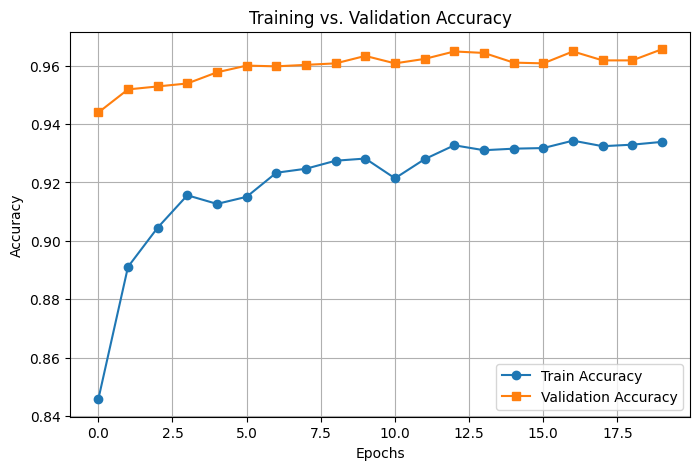

123/123 ━━━━━━━━━━━━━━━━━━━━ 28s 223ms/step - accuracy: 0.9708 - loss: 0.2371
Test accuracy: 0.9656


In [23]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

test_loss, test_acc = model.evaluate(val_generator)
print(f"Test accuracy: {test_acc:.4f}")